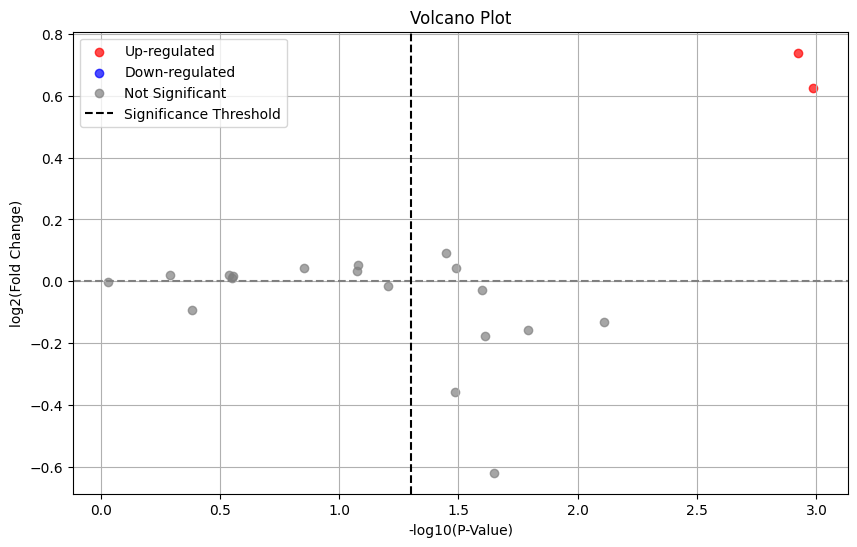

In [1]:
# Step 1: Import required libraries
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.stats import multitest
import matplotlib.pyplot as plt

# Step 2: Load the dataset
data = pd.read_csv('RNA_Seq_Data.csv', index_col=0)

# Step 3: Normalize the counts using CPM (Counts Per Million)
def normalize_counts(counts):
    library_size = counts.sum(axis=0)
    normalized_counts = counts.div(library_size, axis=1) * 1e6
    return normalized_counts

normalized_data = normalize_counts(data)

# Step 4: Perform Differential Expression Analysis using t-test
control = normalized_data.iloc[:, :3]   # Control group
treatment = normalized_data.iloc[:, 3:] # Treatment group

# Perform t-test for each gene
p_values = []
log_fold_changes = []
for gene in normalized_data.index:
    stat, p_value = stats.ttest_ind(control.loc[gene], treatment.loc[gene])
    p_values.append(p_value)
    
    # Calculate log2 fold change (mean of treatment / mean of control)
    mean_control = control.loc[gene].mean()
    mean_treatment = treatment.loc[gene].mean()
    log_fold_change = np.log2(mean_treatment + 1) - np.log2(mean_control + 1)
    log_fold_changes.append(log_fold_change)

# Step 5: Create a DataFrame with results
results = pd.DataFrame({
    'Gene': normalized_data.index,
    'P_Value': p_values,
    'Log2_Fold_Change': log_fold_changes
})

# Step 6: Adjust p-values for multiple testing (FDR)
results['Adjusted_P_Value'] = multitest.multipletests(results['P_Value'], method='fdr_bh')[1]

# Step 7: Add significance category
results['Category'] = 'Not Significant'  # Default
results.loc[(results['Adjusted_P_Value'] < 0.05) & (results['Log2_Fold_Change'] > 0), 'Category'] = 'Up-regulated'
results.loc[(results['Adjusted_P_Value'] < 0.05) & (results['Log2_Fold_Change'] < 0), 'Category'] = 'Down-regulated'

# Step 8: Visualization - Volcano Plot
plt.figure(figsize=(10, 6))

# Plot each category with different colors
colors = {'Up-regulated': 'red', 'Down-regulated': 'blue', 'Not Significant': 'grey'}
for category, color in colors.items():
    subset = results[results['Category'] == category]
    plt.scatter(-np.log10(subset['P_Value']), subset['Log2_Fold_Change'], label=category, color=color, alpha=0.7)

# Add plot titles and labels
plt.title('Volcano Plot')
plt.xlabel('-log10(P-Value)')
plt.ylabel('log2(Fold Change)')
plt.axhline(0, color='grey', linestyle='--')
plt.axvline(-np.log10(0.05), color='black', linestyle='--', label='Significance Threshold')

# Show legend
plt.legend()
plt.grid()
plt.show()
